## Deep Mutational Scanning of Nanopore Amplicon Sequencing Data

This notebook analyzes **Nanopore long-read amplicon** sequencing datasets, which have undergone preprocessing, alignment, and frame correction.

Please make sure to download the input dataset `Nanopore` from the Zenodo repository and place it in a folder named `data` at root repository level.

Before using this notebook for sequence analysis, ensure that the preprocessing script `00_Nanopore_filtering_alignment_processing.sh` has been run. This script performs:

1. Quality filtering of Nanopore reads (`01_Nanopore_read_filtering.py`)
2. Alignment to the reference sequence (`02_Nanopore_alignment.py`)
3. Correction of indel errors typical of Nanopore sequencing, including frame enforcement to enable codon-level mutation analysis (`03_Nanopore_quality_control.py`)

Alternatively, you may run the scripts in the brackets in the given order to achieve the same result.

For more details, see the `README.md` file in this repository.


---

#### This notebook includes the following steps:
- Calculation of mutation enrichment based on aligned Nanopore reads
- Extraction of enrichment data within the defined AraC-LOV2 region of interest
- Quantification and visualization of insertion and deletion (indel) frequencies across the reference sequence
- Export of enrichment metrics (absolute, relative, and variant-level) for downstream analysis
---


## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [2]:
# --- Import necessary modules ---
import os
import sys
import json
import ast
import csv
import gzip
import pickle as pkl
from importlib import reload
from pathlib import Path

notebook_dir = Path().resolve()
repo_root = notebook_dir.parent.parent 
sys.path.append(str(repo_root))

import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
from Bio.SeqIO import QualityIO
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import patches
from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pysam
from scripts.utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.functions_ import *
from scripts.Nanopore_functions import *

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

avenir_fp = FontProperties(family='Avenir Next', weight='demi', size=fs)

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

In [3]:
# ======================== ANALYSIS PARAMETERS ========================

ref_WT = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCGCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] # from 48 because all reads were cut to this start position during processing of the reads --> see process_Nanopore_reads.py 

ref_R5 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:]## R5

ref_R2 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCTAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCTCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] ## R2


annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']

# --- Sequence region of interest ---
start_arac = ref_WT.index("ttttttggagtaaggaggaaaa".upper()) + len("ttttttggagtaaggaggaaaa")
end_arac = ref_WT.index("ggctaatggagattttcaacatgggct".upper())

## Mutation enrichment calculation and visualization

In [ ]:
# --- Set up analysis parameters ---

barcodenumbers = [ "R2_P1-2_Cycle-1_P-1" ,"R2_P1-2_Cycle-1_P-2", "R2_P1-2_Cycle-1_P-3", "R2_P1-2_Cycle-2_P-1", "R2_P1-2_Cycle-2_P-2", "R2_P1-2_Cycle-2_P-3", "R2_P1-2_Cycle-3_P-1" ] # List of barcode numbers to process
quality = 20  # Minimum quality threshold for filtered reads
data_type = "Codons"   # Mutation type to analyze: "DNA", "AA" (amino acids), or "Codons"
data_folder = "Nanopore/Nanopore_P0115"  # Folder containing the processed data

# --- Iterate through each barcode sample ---
for barcode in barcodenumbers:

    # --- Load cleaned, high-quality reads from CSV ---
    with open(f"{repo_root}/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f: # please set the right path
        reader = csv.reader(f)
        all_reads = list(reader)
    
    # --- Extract read strings from list of lists ---
    all_reads = [read[0] for read in all_reads]
    print(len(all_reads), "total reads are analyzed")
    
    # --- Set the correct reference and annotation depending on barcode ---
    ref = ref_WT # <- Change accordingly!!!
    annots = annots_WT # <- Change accordingly!!!

    # --- Load indel data and normalize by total read count ---
    indels = pd.read_csv(f"{repo_root}/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0) ## please set the right path
    indels = indels/len(all_reads)

    # --- Run mutation enrichment analysis for the given read set ---
    all_variants, enrichment_counts,enrichment_relative, indels_freq = characterize_DMS_Nanopore(aligned_reads = all_reads, ref = ref, data_type = data_type)

    # --- Define output folder and create it if not exists ---
    output_folder = f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen" ## please set the right path
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # --- Save full enrichment results ---
    enrichment_counts.to_csv(f"{output_folder}/enrichment_counts_{data_type}.csv")
    enrichment_relative.to_csv(f"{output_folder}/enrichment_relative_{data_type}.csv")
    all_variants.to_csv(f"{output_folder}/all_variants_{data_type}.csv")

    # --- Extract ROI from the enrichment matrix ---
    if data_type == "AA" or data_type == "Codons": 
        araclov2_enr = enrichment_relative.iloc[:,start_arac//3:end_arac//3]
        araclov2_enr.columns = annots if data_type == "AA" else [ref[i:i+3]+str(int(i/3)) for i in range(start_arac,end_arac,3)]
        araclov2_enr.to_csv(f"{output_folder}/enrichment_relative_roi_{data_type}.csv")
    else: 
        araclov2_enr = enrichment_relative.iloc[:,start_arac:end_arac]
        araclov2_enr.columns = [ref_nt + str(i) for i, ref_nt in enumerate(ref[start_arac:end_arac])]
        araclov2_enr.to_csv(f"{output_folder}/enrichment_relative_roi_{data_type}.csv")

    print(barcode +" done")

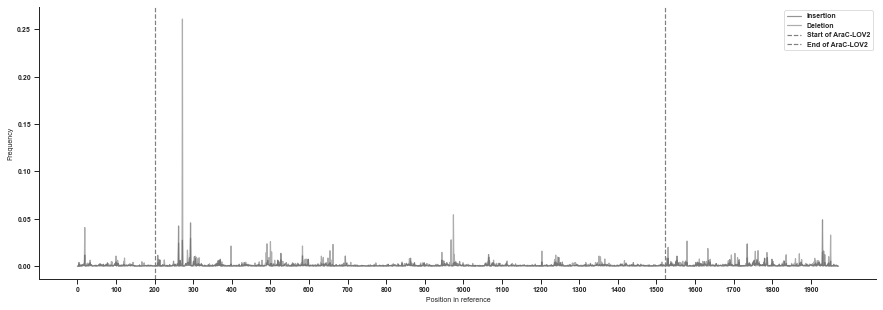

In [ ]:
# --- Plot the observed indel frequencies across the reference sequence ---
fig, axes = plt.subplots(figsize=(15, 5))  # Create a wide figure for better resolution

# --- Plot insertion and deletion frequencies ---
plt.plot(indels.loc["I"], label="Insertion", alpha=0.5)
plt.plot(indels.loc["D"], label="Deletion", alpha=0.5)

# --- Add vertical lines to indicate the start and end of the AraC-LOV2 region ---
plt.axvline(start_arac - 48, color="grey", linestyle="--", label="Start of AraC-LOV2")
plt.axvline(end_arac - 48, color="grey", linestyle="--", label="End of AraC-LOV2")

# --- Customize x-axis ticks for better readability ---
plt.xticks(
    list(range(0, len(indels.columns), 100)),  # Tick positions
    list(range(0, len(indels.columns), 100))   # Tick labels
)

# --- Add axis labels and legend ---
plt.xlabel("Position in reference")
plt.ylabel("Frequency")
plt.legend()

# --- Display the plot ---
plt.show()

In [9]:
# --- plot mutation enrichment e.g. for AraC-LOV2 region after the DMS-library (barcode 23) ---
notebook_dir = Path().resolve()
repo_root = notebook_dir.parent.parent 

data_folder = "Nanopore/Nanopore_P0115"
barcode = "DMS_Library_Single_Passage"
quality = 20
data_type = "AA"
FigFolder = f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/"


all_variants = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
araclov2_enr = pd.read_csv(f"{repo_root}/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)

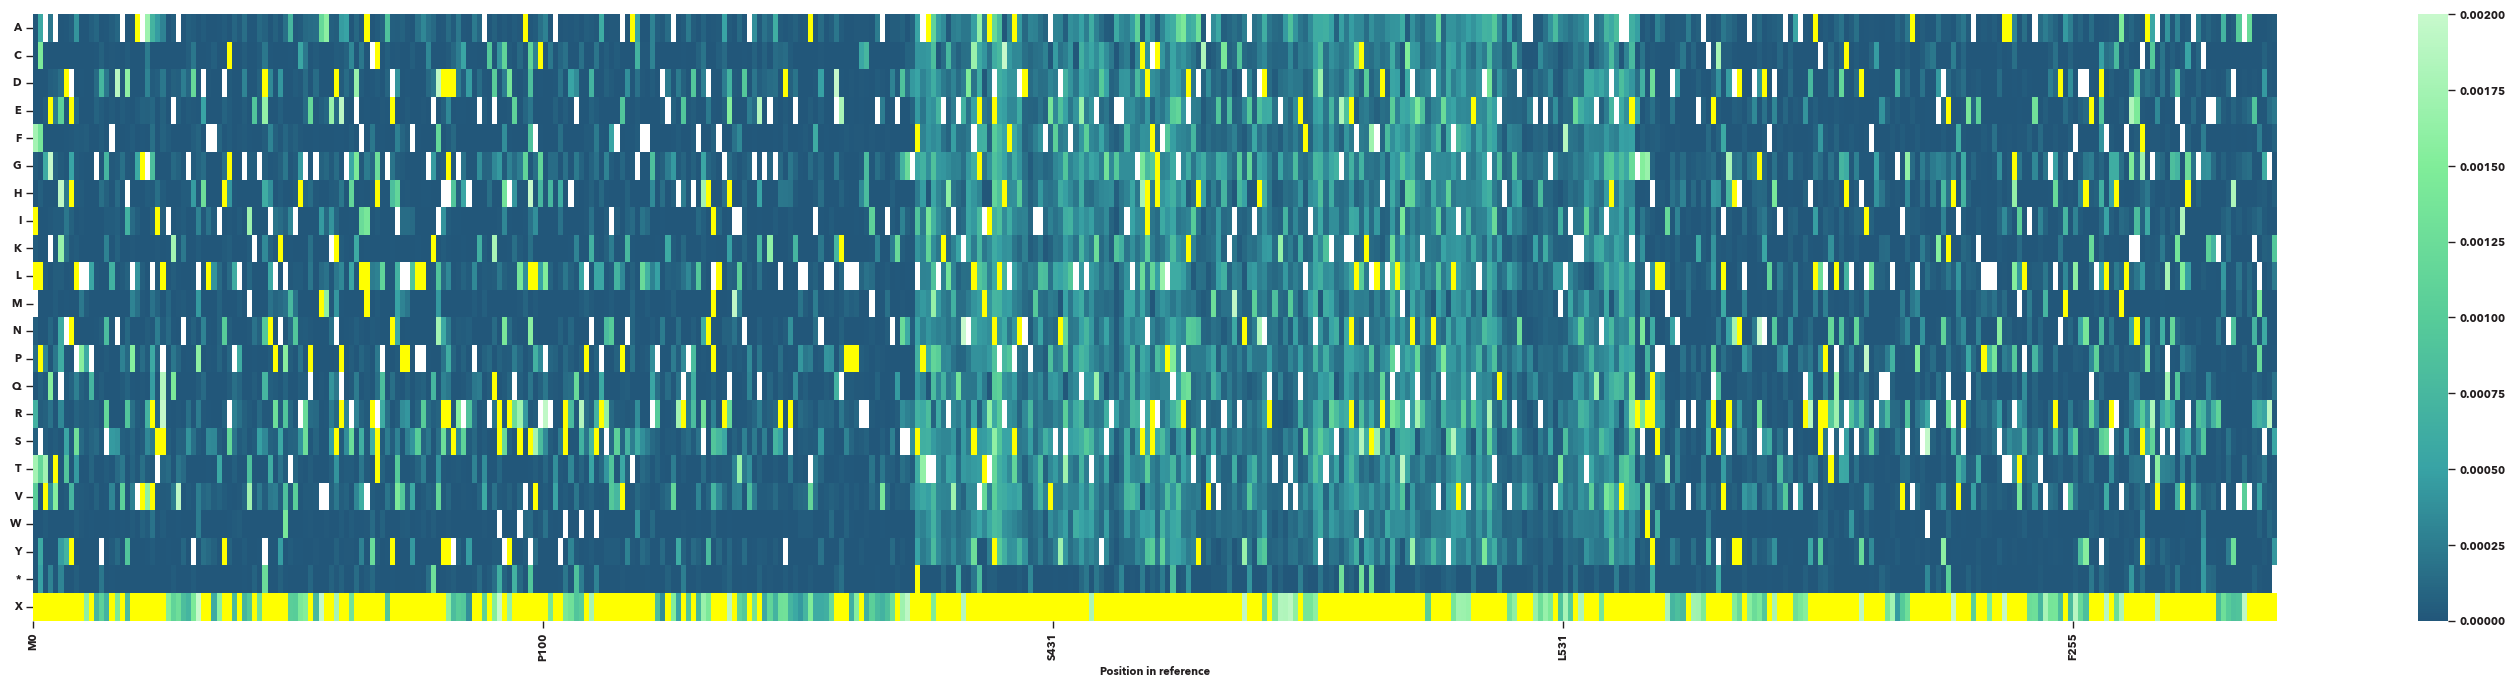

In [10]:
plt.figure(figsize=(wi1*5, hi))

my_cmap = custom_cmap
my_cmap.set_over('Yellow')

# Plot with no xticklabels for now
sns.heatmap(araclov2_enr, cmap=custom_cmap, xticklabels=False, yticklabels=True, vmax=0.002)

# Get original labels from the DataFrame
original_labels = araclov2_enr.columns
tick_positions = list(range(0, len(original_labels), 100))
tick_labels = [original_labels[i] for i in tick_positions]


# Apply every 100th label
plt.xticks(tick_positions, tick_labels, rotation=90)
plt.yticks(rotation = 0)

plt.xlabel("Position in reference")
# plt.savefig(f"{FigFolder}/mutation_enrichment.pdf", bbox_inches="tight", dpi=600)
# plt.savefig(f"{FigFolder}/mutation_enrichment.png", bbox_inches="tight", dpi=600)
# print(f"{FigFolder}/mutation_enrichment.pdf")
plt.show()

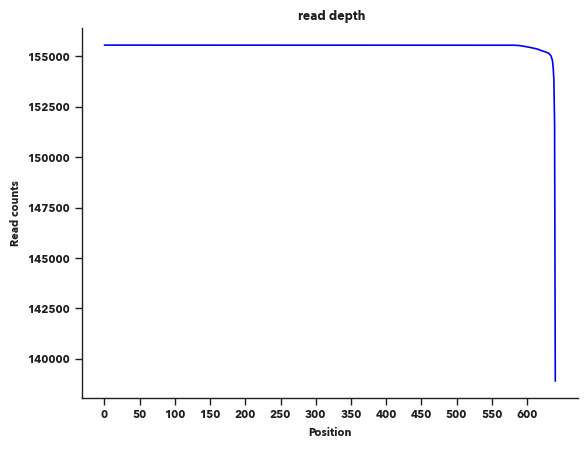

In [11]:
## plot the coverage 
coverage_plot(all_variants.sum())